# Fig3f - ROI-based Fluorescence Intensity Analysis

## Overview
This script processes time-lapse fluorescence microscopy images from two channels (e.g., membrane and mabojin) and calculates the average intensity within a user-defined Region of Interest (ROI).  
The ROI is defined by polygon annotations stored in JSON files. The script matches corresponding frames across both channels, extracts ROI intensities, normalizes them, and generates both numerical data and plots of intensity over time.

## Input Requirements
1. **Two directories containing TIF images**:
   - **Membrane channel** images
   - **mabojin channel** images
   Filenames must include timepoint identifiers.

2. **ROI annotation JSON files**:
   - Generated from an image annotation tool (e.g., LabelMe)
   - Polygon coordinates must match the corresponding TIF image frames.
   - The JSON filename should include the timepoint identifier to allow matching.

3. **User-configurable parameters** inside the script:
   - `membrane_dir`: path to the membrane channel folder
   - `mbaojin_dir`: path to the mabojin channel folder
   - `output_svg_file`: path to save the output plot
   - `output_csv_file`: path to save the numerical results
   - `time_per_frame`: acquisition interval (in minutes) between frames

## Outputs
1. **CSV file** containing:
   - Frame number and acquisition time
   - Raw ROI intensities for both channels
   - Normalized intensities (relative to peak value in each channel)

2. **SVG plot** showing:
   - Normalized intensity vs. time for both channels
   - Styled with distinct colors and labeled axes

3. **Console output**:
   - File mapping logs
   - ROI intensity values for each timepoint
   - Summary statistics for raw and normalized intensities

## How to Run
1. **Set paths**:  
   Update `membrane_dir`, `mabojin_dir`, `output_svg_file`, and `output_csv_file` in the script to match your dataset.

2. **Configure analysis parameters**:  
   Adjust `time_per_frame` and any other settings if needed.

3. **Run all cells in order**:  
   Execute the Jupyter Notebook from top to bottom.

4. **Check output files in the specified directory**:  
   - CSV file with intensity data  
   - SVG plot of normalized intensities

=== File Mapping ===
t01: full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t01c2.tif + full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t01c1.tif -> full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t01c2.json (from c1)
t02: full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t02c2.tif + full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t02c1.tif -> full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t02c2.json (from c1)
t03: full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t03c2.tif + full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t03c1.tif -> full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t03c2.json (from c1)
t04: full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t04c2.tif + full-frap_250121-Create Image Subset and Split-11-Airyscan Processing-12_t04c1.

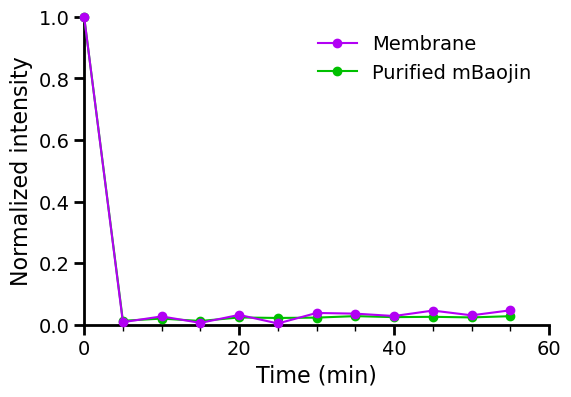

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from PIL import Image
import json
import os
import re
import glob

# --- User-configurable parameters ---
# Replace with your actual file paths
membrane_dir = '/Users/jyzerresico/chenlab/Synthetic Division/FigS3c/full-frap_250121/c2'
mbaojin_dir = '/Users/jyzerresico/chenlab/Synthetic Division/FigS3c/full-frap_250121/c1'
output_svg_file = '/Users/jyzerresico/chenlab/Synthetic Division/FigS3c/FigS3c.svg'
output_csv_file = '/Users/jyzerresico/chenlab/Synthetic Division/FigS3c/FigS3c_intensity_data.csv'

# Time interval per frame (in minutes)
time_per_frame = 5

# --- Helper functions ---
def extract_timepoint(filename):
    """Extract timepoint number from filename for sorting"""
    match = re.search(r't(\d+)', filename)
    return int(match.group(1)) if match else 0

def read_tif_as_grayscale(tif_path):
    """Read TIF file in grayscale mode and return numpy array"""
    with Image.open(tif_path) as img:
        # Convert to grayscale mode
        gray_img = img.convert('L')
        return np.array(gray_img)

def find_json_file(timepoint, membrane_dir, mbaojin_dir):
    """Find JSON annotation file for given timepoint in either directory"""
    # Common patterns for JSON files
    patterns = [
        f'*t{timepoint:02d}*.json',
        f'*_t{timepoint:02d}_*.json',
        f'*-t{timepoint:02d}-*.json'
    ]
    
    # Search in both directories
    for directory in [membrane_dir, mbaojin_dir]:
        if os.path.exists(directory):
            for pattern in patterns:
                json_files = glob.glob(os.path.join(directory, pattern))
                if json_files:
                    return json_files[0]  # Return first match
    
    return None

def calculate_roi_intensity(image_array, json_path):
    """Calculate average intensity based on ROI coordinates from JSON file"""
    if not json_path or not os.path.exists(json_path):
        return None, None
    
    with open(json_path, 'r') as f:
        annotation = json.load(f)
    
    if not annotation.get('shapes'):
        return None, None
    
    # Get coordinates of the first shape
    points = annotation['shapes'][0]['points']
    
    # Create mask
    from PIL import Image, ImageDraw
    mask = Image.new('L', (image_array.shape[1], image_array.shape[0]), 0)
    ImageDraw.Draw(mask).polygon([tuple(point) for point in points], outline=1, fill=1)
    mask_array = np.array(mask)
    
    # Calculate average intensity within ROI
    roi_pixels = image_array[mask_array == 1]
    return np.mean(roi_pixels) if len(roi_pixels) > 0 else None, mask_array

def create_file_mapping(membrane_dir, mbaojin_dir):
    """Create mapping between Membrane and mBaojin files"""
    # Get TIF files from Membrane directory
    membrane_tif_files = [f for f in os.listdir(membrane_dir) if f.endswith('.tif')]
    membrane_tif_files.sort(key=extract_timepoint)
    
    # Get TIF files from mBaojin directory
    mbaojin_tif_files = [f for f in os.listdir(mbaojin_dir) if f.endswith('.tif')]
    mbaojin_tif_files.sort(key=extract_timepoint)
    
    # Create file mapping
    file_mapping = []
    
    print("=== File Mapping ===")
    for i, membrane_file in enumerate(membrane_tif_files):
        membrane_timepoint = extract_timepoint(membrane_file)
        
        # Find corresponding mBaojin file
        mbaojin_file = None
        for mbaojin_f in mbaojin_tif_files:
            if extract_timepoint(mbaojin_f) == membrane_timepoint:
                mbaojin_file = mbaojin_f
                break
        
        # Find JSON file in either directory
        json_file_path = find_json_file(membrane_timepoint, membrane_dir, mbaojin_dir)
        
        if mbaojin_file and json_file_path:
            mapping = {
                'timepoint': membrane_timepoint,
                'membrane_tif': membrane_file,
                'mbaojin_tif': mbaojin_file,
                'json_path': json_file_path
            }
            file_mapping.append(mapping)
            json_filename = os.path.basename(json_file_path)
            json_dir = 'c1' if membrane_dir in json_file_path else 'c2'
            print(f"t{membrane_timepoint:02d}: {membrane_file} + {mbaojin_file} -> {json_filename} (from {json_dir})")
        else:
            missing = []
            if not mbaojin_file:
                missing.append(f"mBaojin file for {membrane_file}")
            if not json_file_path:
                missing.append(f"JSON annotation for t{membrane_timepoint:02d}")
            print(f"Warning: Missing {', '.join(missing)}")
    
    print(f"\nTotal mappings created: {len(file_mapping)}\n")
    return file_mapping

def process_mapped_files(file_mapping, membrane_dir, mbaojin_dir):
    """Process mapped files and calculate ROI intensities for both channels"""
    data = []
    membrane_intensities = []
    mbaojin_intensities = []
    
    print("=== Processing Files and Calculating ROI Intensities ===")
    
    for mapping in file_mapping:
        timepoint = mapping['timepoint']
        membrane_tif_path = os.path.join(membrane_dir, mapping['membrane_tif'])
        mbaojin_tif_path = os.path.join(mbaojin_dir, mapping['mbaojin_tif'])
        json_path = mapping['json_path']
        
        # Read Membrane image
        membrane_image = read_tif_as_grayscale(membrane_tif_path)
        
        # Read mBaojin image
        mbaojin_image = read_tif_as_grayscale(mbaojin_tif_path)
        
        # Get ROI from JSON file and apply to both channels
        membrane_intensity, roi_mask = calculate_roi_intensity(membrane_image, json_path)
        
        if membrane_intensity is not None and roi_mask is not None:
            # Apply same ROI to mBaojin image
            mbaojin_roi_pixels = mbaojin_image[roi_mask == 1]
            mbaojin_intensity = np.mean(mbaojin_roi_pixels) if len(mbaojin_roi_pixels) > 0 else 0
            
            # Adjust time to start from 0 (first frame at x=0)
            time_adjusted = (timepoint - 1) * time_per_frame
            
            data.append({
                'Frame': timepoint,
                'Time/min': time_adjusted,
                'Membrane_Raw_Intensity': membrane_intensity,
                'mBaojin_Raw_Intensity': mbaojin_intensity
            })
            
            membrane_intensities.append(membrane_intensity)
            mbaojin_intensities.append(mbaojin_intensity)
            
            print(f"t{timepoint:02d}: Membrane_ROI={membrane_intensity:.2f}, mBaojin_ROI={mbaojin_intensity:.2f}")
        else:
            print(f"Warning: t{timepoint:02d} unable to obtain ROI information")
    
    df = pd.DataFrame(data)
    
    # Peak normalization
    if len(membrane_intensities) > 0:
        membrane_max = max(membrane_intensities)
        if membrane_max > 0:
            df['Membrane_Normalized_Intensity'] = df['Membrane_Raw_Intensity'] / membrane_max
        else:
            df['Membrane_Normalized_Intensity'] = 0.0
    else:
        df['Membrane_Normalized_Intensity'] = 0.0
    
    if len(mbaojin_intensities) > 0:
        mbaojin_max = max(mbaojin_intensities)
        if mbaojin_max > 0:
            df['mBaojin_Normalized_Intensity'] = df['mBaojin_Raw_Intensity'] / mbaojin_max
        else:
            df['mBaojin_Normalized_Intensity'] = 0.0
    else:
        df['mBaojin_Normalized_Intensity'] = 0.0
    
    return df

# --- Main execution ---
try:
    # Create file mapping
    file_mapping = create_file_mapping(membrane_dir, mbaojin_dir)
    
    # Process mapped files
    df_combined = process_mapped_files(file_mapping, membrane_dir, mbaojin_dir)
    
    print(f"\n=== Processing Results ===")
    print(f"Successfully processed {len(df_combined)} timepoints")
    print("Data preview:")
    print(df_combined.head())
    
    # Save to CSV file
    df_combined.to_csv(output_csv_file, index=False)
    print(f"\nData successfully saved to CSV file: {output_csv_file}")

    # Create line plot
    plt.figure(figsize=(6, 4))

    purple_color = '#B200F4'
    green_color = '#00C000'

    ax = plt.gca()

    # Plot Membrane data (purple)
    ax.plot(
        df_combined['Time/min'],
        df_combined['Membrane_Normalized_Intensity'],
        marker='o',
        markersize=6,
        color=purple_color,
        label='Membrane',
        zorder=10,
        clip_on=False
    )

    # Plot mBaojin data (green)
    ax.plot(
        df_combined['Time/min'],
        df_combined['mBaojin_Normalized_Intensity'],
        marker='o',
        markersize=6,
        color=green_color,
        label='Purified mBaojin',
        zorder=5,
        clip_on=False
    )

    # Set chart title and axis labels
    ax.set_xlabel('Time (min)', fontsize=16)
    ax.set_ylabel('Normalized intensity', fontsize=16)

    # Set X and Y axis tick font sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=14)
    ax.tick_params(axis='x', which='minor', length=4, width=1)
    ax.tick_params(axis='y', which='major', length=7, width=2, labelsize=14)


    # Set Y axis range and ticks
    ax.set_ylim(0, 1)
    ax.set_yticks(
        ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
    )

    # Set Y axis range and ticks
    ax.set_xlim(0,60)

    # Display legend
    ax.legend(
        loc='upper right',
        fontsize=14,
        frameon=False
    )

    # Remove top and right borders and adjust axis line width
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Save image as SVG file
    plt.savefig(output_svg_file, format='svg', bbox_inches='tight', dpi=300)
    print(f"Image successfully saved to: {output_svg_file}")
    
    # Display statistics
    print(f"\n=== Intensity Statistics ===")
    print(f"Membrane intensity statistics:")
    print(f"  Raw intensity range: {df_combined['Membrane_Raw_Intensity'].min():.2f} - {df_combined['Membrane_Raw_Intensity'].max():.2f}")
    print(f"  Normalized range: {df_combined['Membrane_Normalized_Intensity'].min():.2f} - {df_combined['Membrane_Normalized_Intensity'].max():.2f}")
    
    print(f"\nmBaojin intensity statistics:")
    print(f"  Raw intensity range: {df_combined['mBaojin_Raw_Intensity'].min():.2f} - {df_combined['mBaojin_Raw_Intensity'].max():.2f}")
    print(f"  Normalized range: {df_combined['mBaojin_Normalized_Intensity'].min():.2f} - {df_combined['mBaojin_Normalized_Intensity'].max():.2f}")
    

except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()